In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar


In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape


(62, 231563)

In [4]:
indx = np.isfinite(data_loaded["best18k Parallax fiveSigmaDepth, band, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].values)
data_loaded.loc[indx, ["best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"]] = data_loaded["best18k Parallax fiveSigmaDepth, band, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer"].iloc[indx]

#for bandname in 'ugrizy':
#    indx = np.isfinite(data_loaded["Median CoaddM5 band%s HealpixSlicer" % bandname].values)
#    d1 = data_loaded["Median CoaddM5 %s HealpixSlicer" % bandname].values
#    d1[indx] = data_loaded["Median CoaddM5 band%s HealpixSlicer" % bandname].iloc[indx].values
#    data_loaded["Median CoaddM5 %s HealpixSlicer" % bandname] = d1

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
             #'fOArea_750 fO All sky HealpixSlicer': 'fO Area 750',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color slope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
             'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 3 pairs in 15 nights SNR=5 detection loss MoObjSlicer': 'Vatira 3pairs, 15days, snr=5',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad',
            'Fraction detected of total (mean) KNePopMetric_single_multi_color_detect single model UserPointsSlicer': "KNe\n multi-color"}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'fO Area 750': '',
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'Vatira 3pairs, 15days, snr=5': "fraction",
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color slope': 'N',
         '2day\ncolor slope': 'N',
         "KNe\n multi-color": "fraction",
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
# [name for name in mag_data.index if "prod" in name]

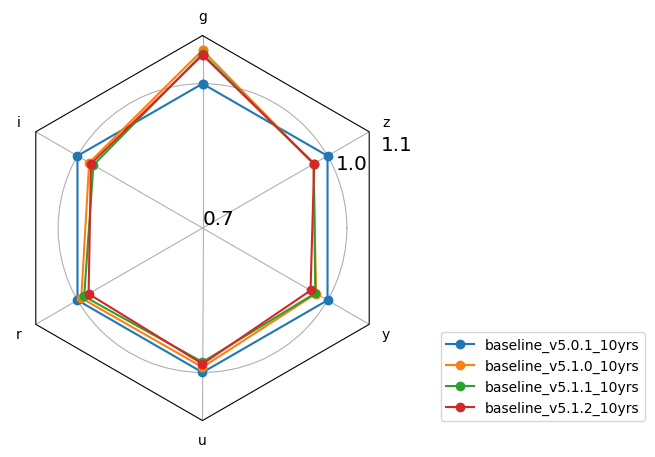

In [7]:
runs = ['baseline_v5.0.1_10yrs', 'baseline_v5.1.0_10yrs', 'baseline_v5.1.1_10yrs', 'baseline_v5.1.2_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v5.0.1_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.65, 0))


In [8]:
mag_data.loc[runs]

,g,i,r,u,y,z
run_name,,,,,,
baseline_v5.0.1_10yrs,26.771999,26.380218,26.886796,25.530906,24.771967,25.726439
baseline_v5.1.0_10yrs,26.841646,26.352092,26.877636,25.520009,24.744487,25.692871
baseline_v5.1.1_10yrs,26.833940,26.341946,26.870721,25.509416,24.742645,25.693209
baseline_v5.1.2_10yrs,26.831434,26.347789,26.860108,25.513278,24.731224,25.694410


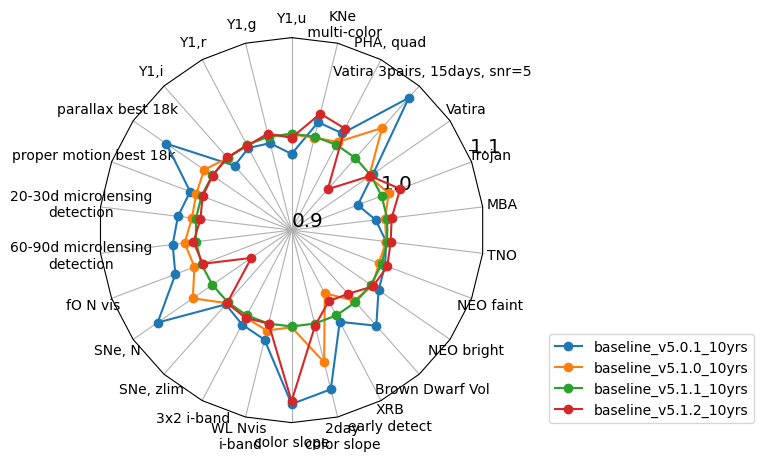

In [9]:
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.7, 0))


In [10]:
ndata

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad",KNe\n multi-color
run_name,,,,,,,,,,,,,,,,,,,,,
baseline_v5.0.1_10yrs,0.979114,0.993015,0.996410,0.989359,1.058165,1.012713,1.0189,1.0245,1.029101,1.069119,...,1.032732,1.0098,1.003829,0.999004,0.987960,0.973525,1.0030,1.083614,1.013473,1.015469
baseline_v5.1.0_10yrs,0.999294,1.000748,0.999629,1.000124,1.010361,1.005938,1.0043,1.0119,1.007937,1.024716,...,0.997844,1.0022,0.996985,0.999007,0.997841,1.007888,0.9978,1.041807,1.003497,0.998977
baseline_v5.1.1_10yrs,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.0000,1.000000,1.000000,...,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
baseline_v5.1.2_10yrs,0.995907,1.003243,0.999010,1.000990,0.999765,0.998855,0.9954,1.0027,0.998677,0.950827,...,0.988478,1.0028,1.006325,1.003693,1.004732,1.020689,0.9991,0.956752,1.019164,1.024677


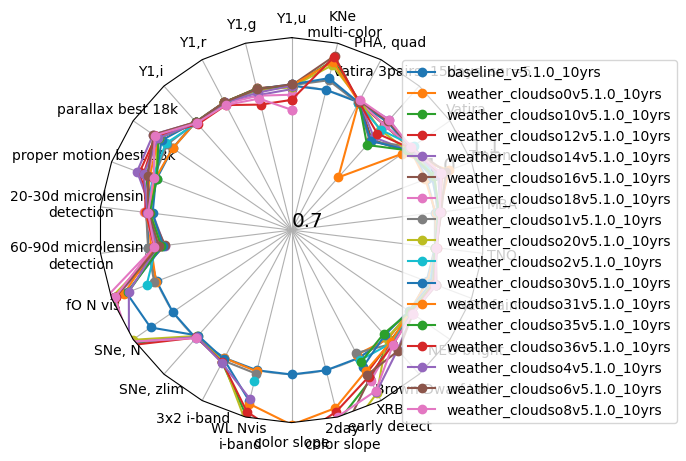

In [11]:
runs = ['baseline_v5.1.0_10yrs'] + [run for run in data_loaded.index if 'weather' in run and "5.1.0" in run and "poor" not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


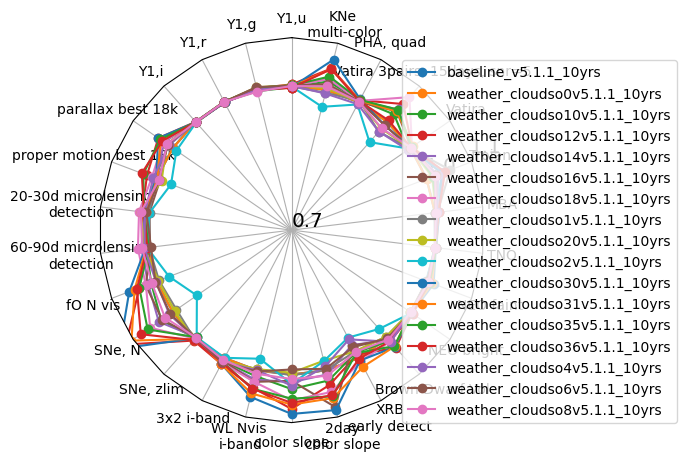

In [12]:
runs = ['baseline_v5.1.1_10yrs'] + [run for run in data_loaded.index if 'weather' in run and "5.1.1" in run and "poor" not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


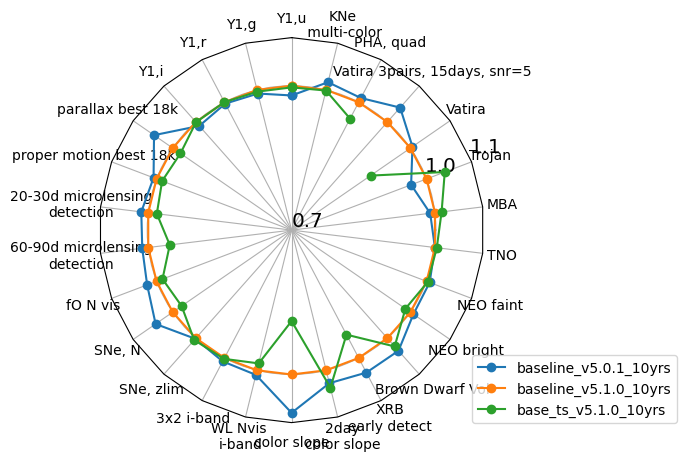

In [13]:
runs = ['baseline_v5.0.1_10yrs', 'baseline_v5.1.0_10yrs'] + [run for run in data_loaded.index if 'base_ts' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


In [14]:
ndata

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad",KNe\n multi-color
run_name,,,,,,,,,,,,,,,,,,,,,
baseline_v5.0.1_10yrs,0.979805,0.992272,0.996780,0.989237,1.047315,1.006736,1.0146,1.0126,1.020997,1.043332,...,1.034963,1.0076,1.006844,0.999997,0.990119,0.965636,1.0052,1.040129,1.009941,1.016509
baseline_v5.1.0_10yrs,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.0000,1.000000,1.000000,...,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
base_ts_v5.1.0_10yrs,0.996611,0.996385,1.000372,0.999505,0.980594,0.987732,0.9821,0.9550,0.986877,0.977678,...,1.022964,0.9874,1.002920,1.003891,1.014018,1.040423,0.8994,0.568266,0.961599,0.998689


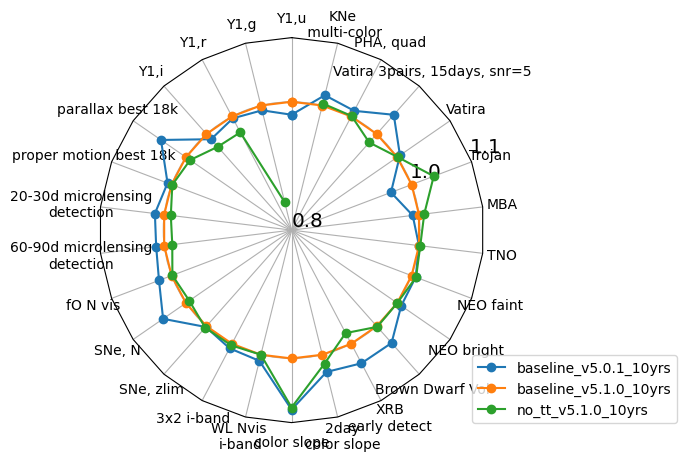

In [15]:
runs = ['baseline_v5.0.1_10yrs', 'baseline_v5.1.0_10yrs'] + [run for run in data_loaded.index if 'no_tt' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


In [16]:
ndata

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad",KNe\n multi-color
run_name,,,,,,,,,,,,,,,,,,,,,
baseline_v5.0.1_10yrs,0.979805,0.992272,0.996780,0.989237,1.047315,1.006736,1.0146,1.0126,1.020997,1.043332,...,1.034963,1.0076,1.006844,0.999997,0.990119,0.965636,1.0052,1.040129,1.009941,1.016509
baseline_v5.1.0_10yrs,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.0000,1.000000,1.000000,...,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000
no_tt_v5.1.0_10yrs,0.419715,0.844821,0.972012,0.973525,0.992209,0.998847,0.9896,0.9873,0.998688,0.993713,...,1.001335,1.0000,1.007456,1.002018,1.008238,1.036920,1.0006,0.982472,1.000976,1.003154


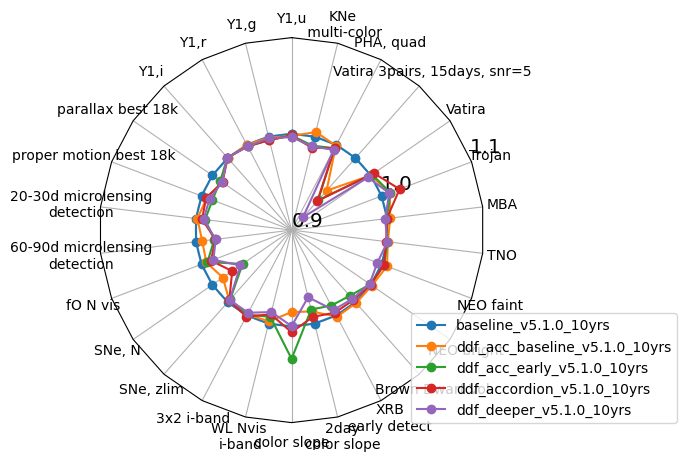

In [17]:
# DDF runs
runs = [ 'baseline_v5.1.0_10yrs'] + [run for run in data_loaded.index if 'ddf' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


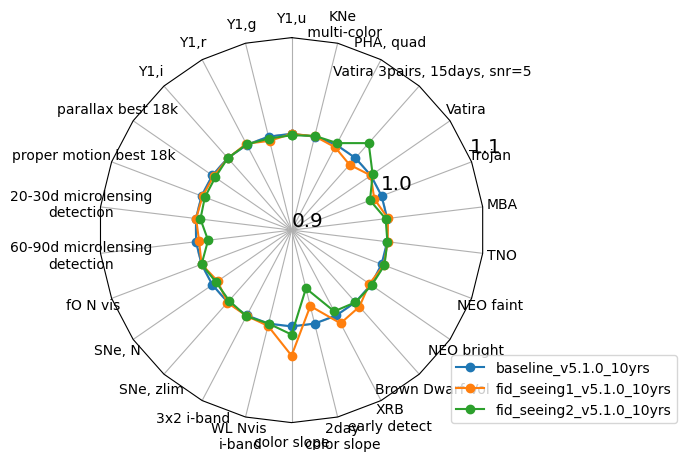

In [18]:
# changing the fiducial exposure time, should be the same
runs = [ 'baseline_v5.1.0_10yrs'] + [run for run in data_loaded.index if 'fid' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


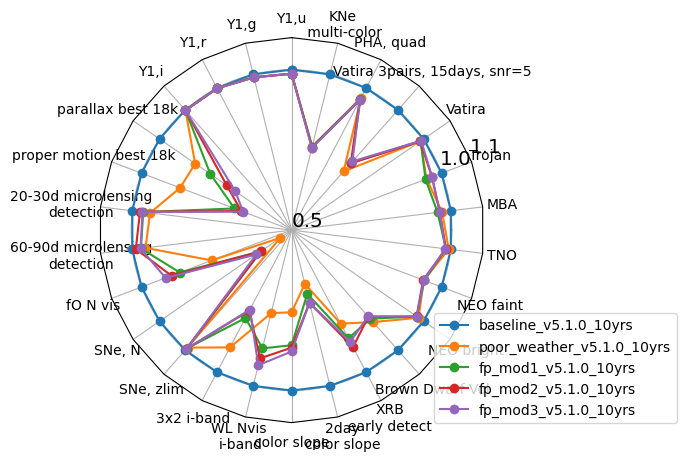

In [19]:
# changing the fiducial exposure time, should be the same
runs = [ 'baseline_v5.1.0_10yrs', "poor_weather_v5.1.0_10yrs"] + [run for run in data_loaded.index if 'fp_' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v5.1.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.1], bbox_to_anchor=(1.5, 0))


In [20]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 
          'baseline_v3.5_10yrs', 'baseline_v3.6_10yrs', 'baseline_v4.0_10yrs', 'baseline_v4.1_10yrs',
         'baseline_v4.2_10yrs', "baseline_v4.3.5_10yrs","baseline_v5.0.1_10yrs",
         "baseline_v5.1.0_10yrs", "baseline_v5.1.1_10yrs","baseline_v5.1.2_10yrs",
        ]

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data

,"Y1,u","Y1,g","Y1,r","Y1,i",parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"Vatira 3pairs, 15days, snr=5","PHA, quad",KNe\n multi-color
run_name,,,,,,,,,,,,,,,,,,,,,
retro_baseline_v2.0_10yrs,0.892997,0.948610,0.960840,0.958493,0.806655,0.177145,0.0877,0.1567,844.0,74866.992902,...,179114.337158,0.9048,0.623987,0.705883,0.943588,0.666843,0.0000,0.0000,0.847360,0.046236
baseline_v2.0_10yrs,0.954102,0.981223,0.994441,0.997035,0.793201,0.184595,0.3116,0.4343,834.0,84521.226481,...,167595.204773,0.9294,0.641643,0.719657,0.918853,0.587761,0.0039,0.0001,0.858612,0.051290
baseline_v2.1_10yrs,0.947824,0.984064,0.996665,0.999012,0.808880,0.188682,0.3138,0.4315,834.0,83126.586481,...,163335.805265,0.9286,0.647493,0.723151,0.927147,0.608476,0.0017,0.0004,0.863941,0.052746
baseline_v2.2_10yrs,0.869001,0.913280,0.993576,0.997900,0.794958,0.186814,0.3263,0.4484,826.0,96102.976188,...,171949.790286,0.9304,0.657326,0.723757,0.933532,0.615050,0.0008,0.0000,0.857143,0.056264
baseline_v3.0_10yrs,0.810826,0.900309,0.993823,0.999135,0.794761,0.186153,0.3227,0.4522,791.0,94711.273608,...,167538.768999,0.9326,0.642039,0.722257,0.923939,0.610659,0.0374,0.0002,0.886783,0.053112
baseline_v3.2_10yrs,0.973214,0.981841,0.996170,0.995800,0.785002,0.185884,0.3429,0.4865,801.0,107287.044585,...,173524.077129,0.9458,0.641833,0.720682,0.926269,0.588185,0.4627,0.2348,0.892336,0.054538
baseline_v3.3_10yrs,0.987165,0.992712,0.997529,0.996294,0.756212,0.179475,0.3815,0.5224,807.0,132932.293442,...,187648.374486,0.9440,0.659439,0.722520,0.942300,0.629354,0.4601,0.2316,0.905774,0.058824
baseline_v3.4_10yrs,0.980887,0.990241,0.995182,0.997406,0.754666,0.178122,0.3650,0.5174,812.0,132121.474272,...,188148.511393,0.9472,0.666934,0.727676,0.943417,0.633808,0.4633,0.2352,0.902250,0.059110
baseline_v3.5_10yrs,0.982561,0.995059,0.998888,0.997406,0.749014,0.176342,0.3729,0.5189,799.0,114367.709815,...,181160.990452,0.9468,0.668745,0.725868,0.938182,0.603993,0.4664,0.2391,0.910419,0.058878


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_75558/3030795276.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


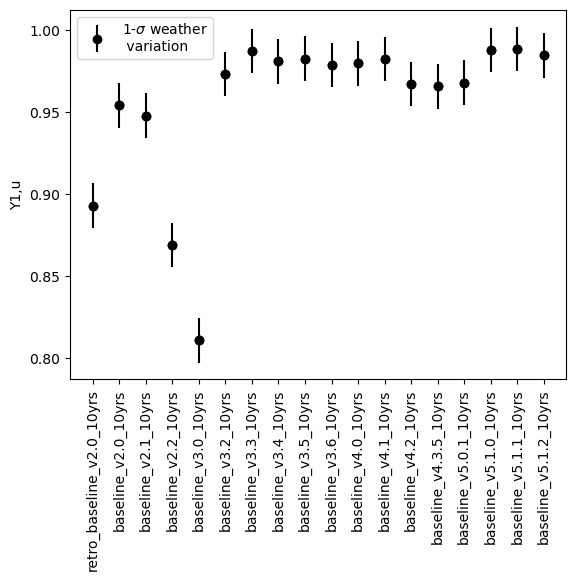

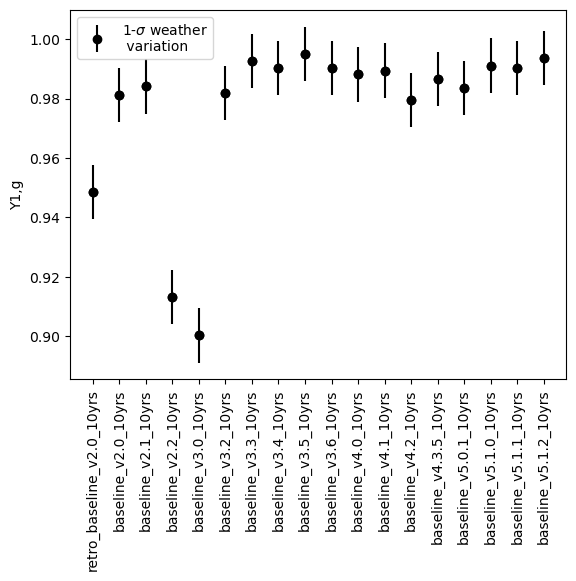

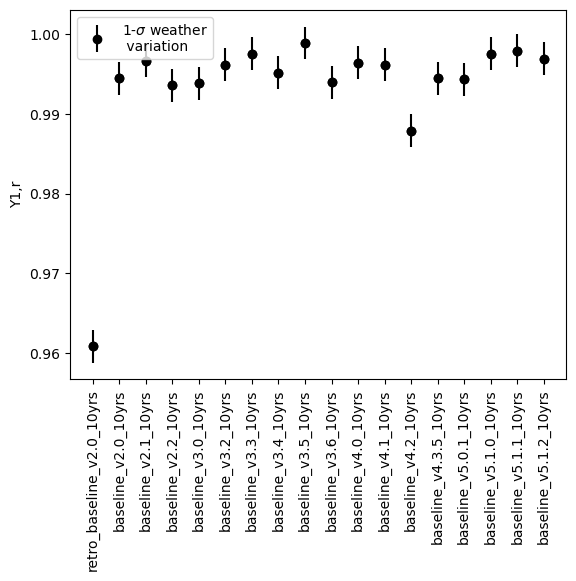

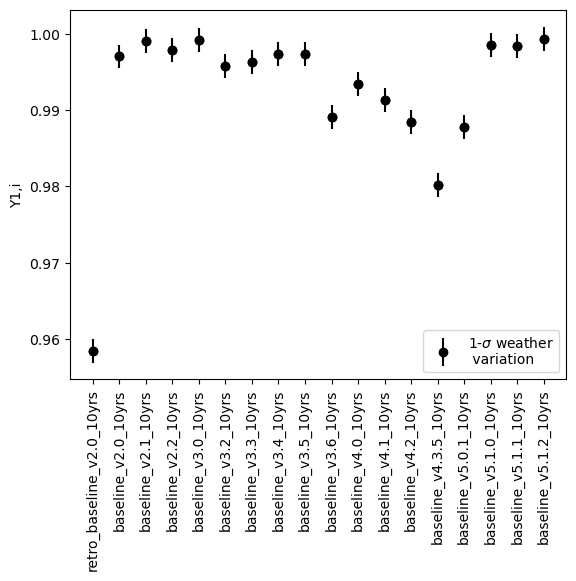

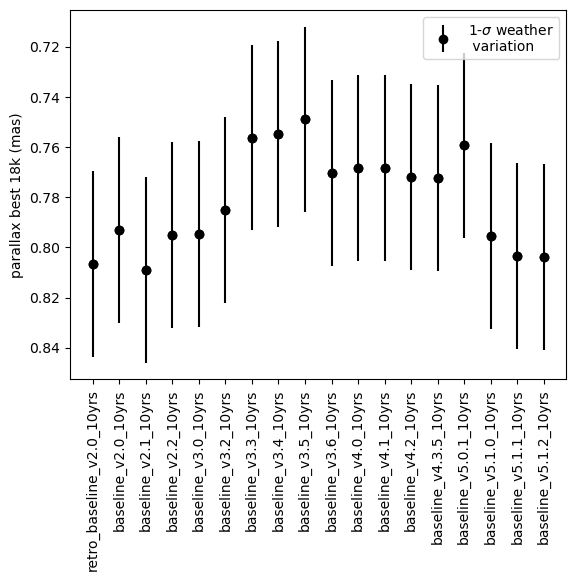

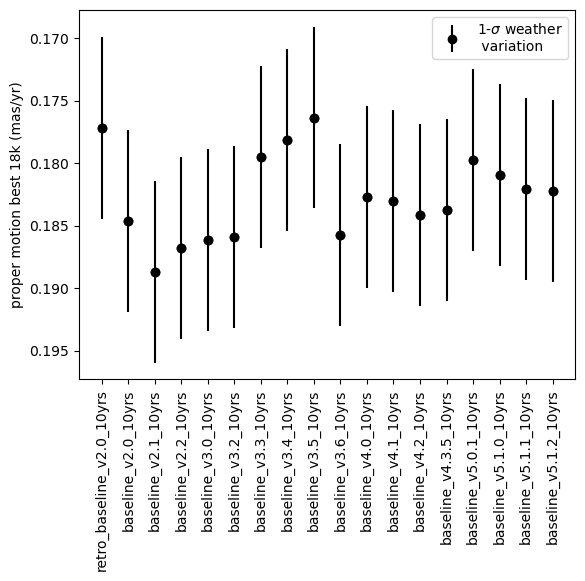

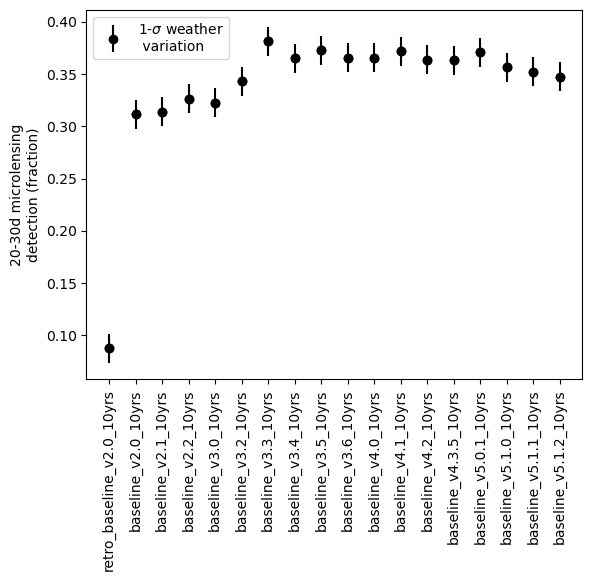

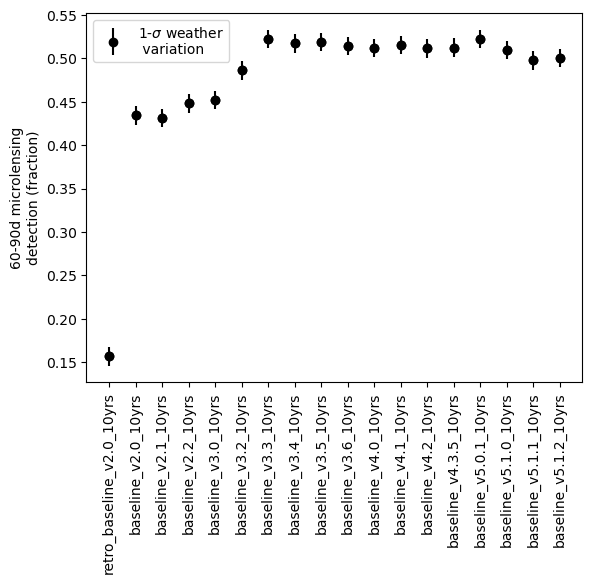

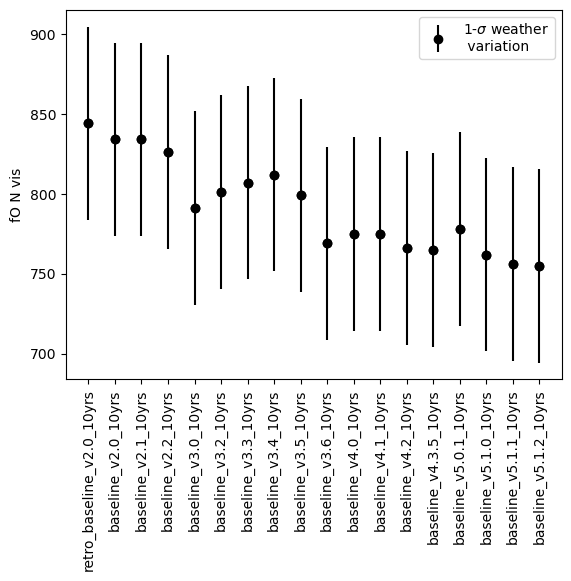

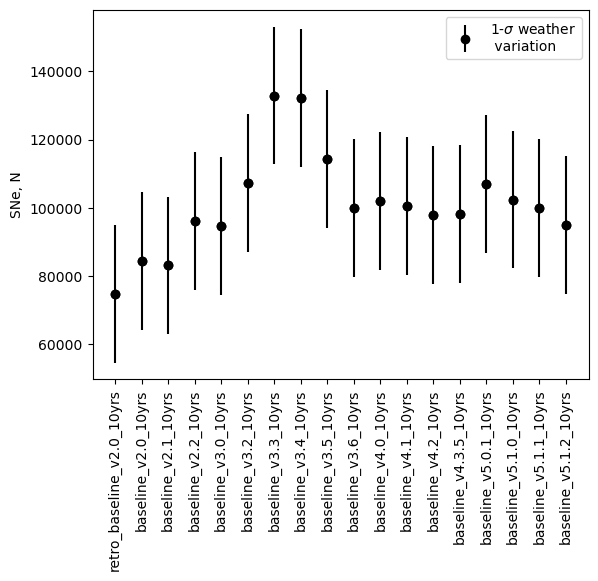

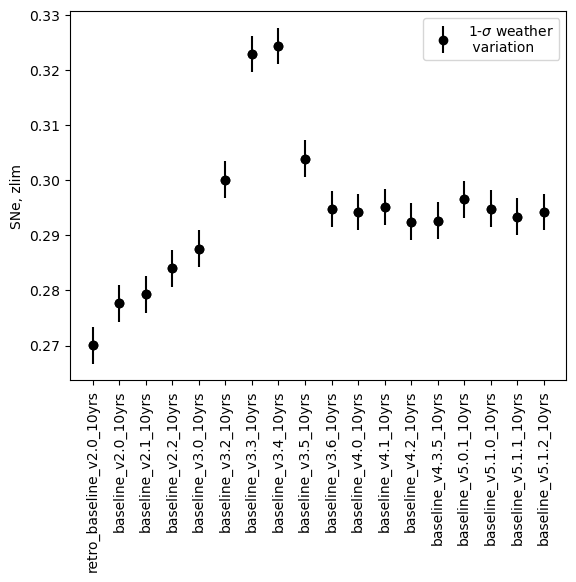

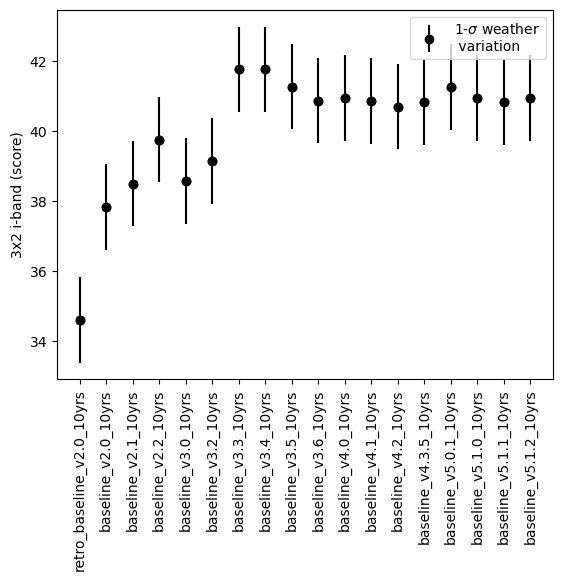

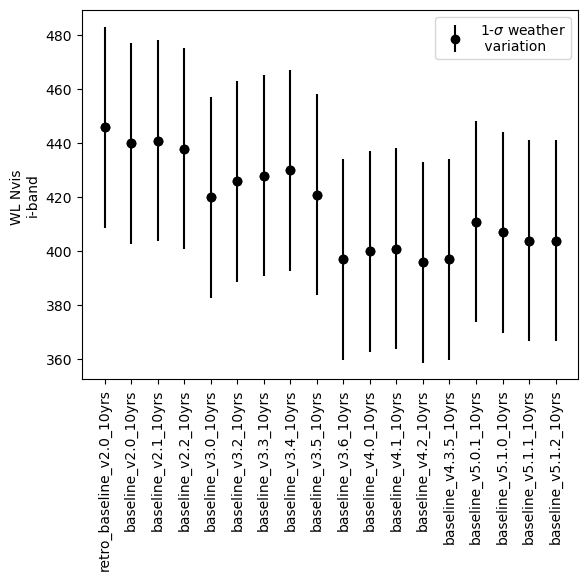

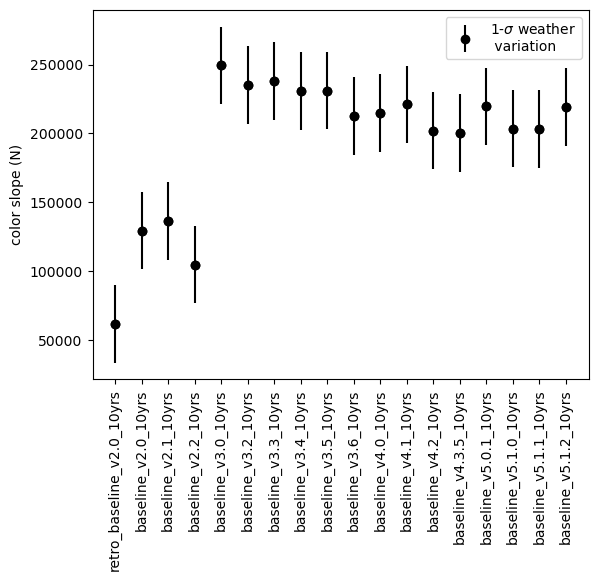

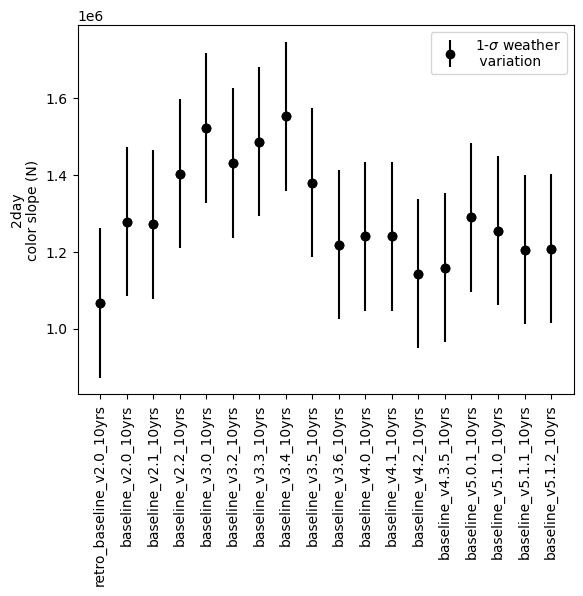

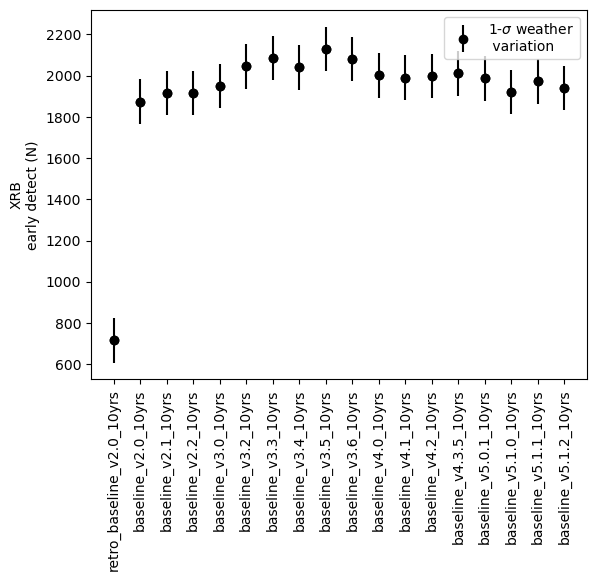

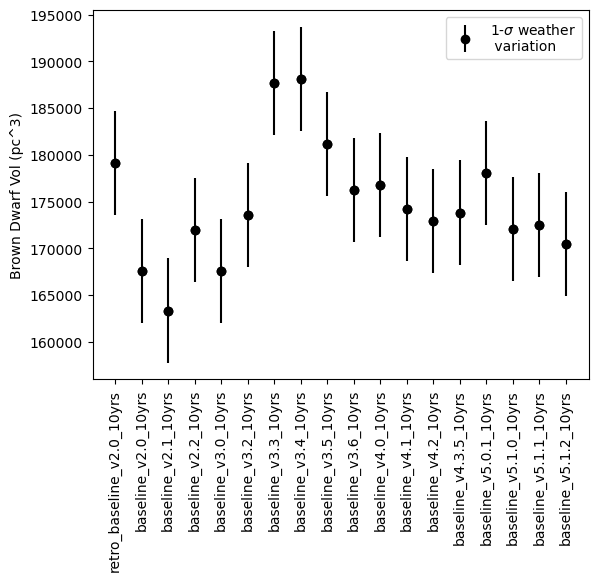

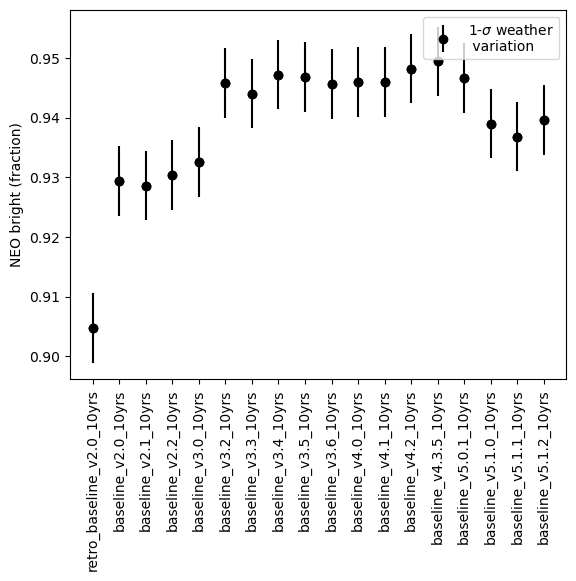

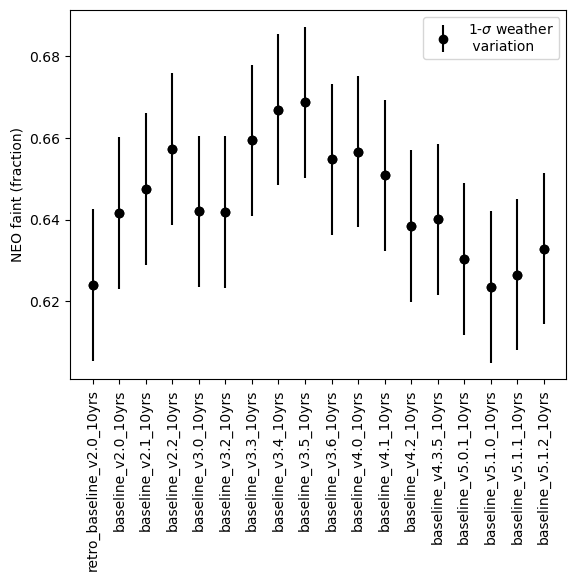

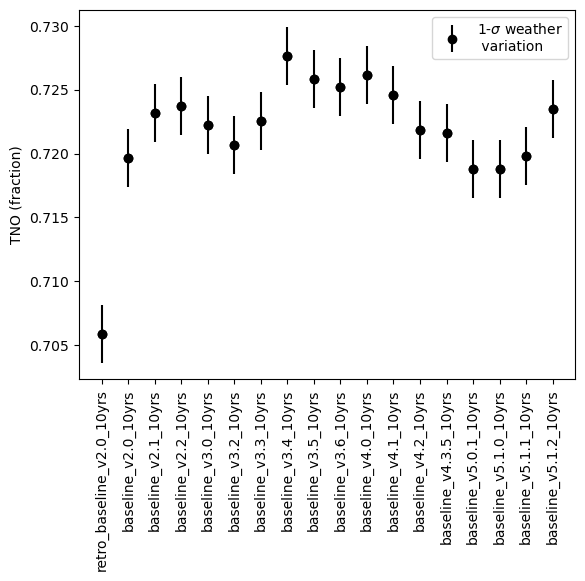

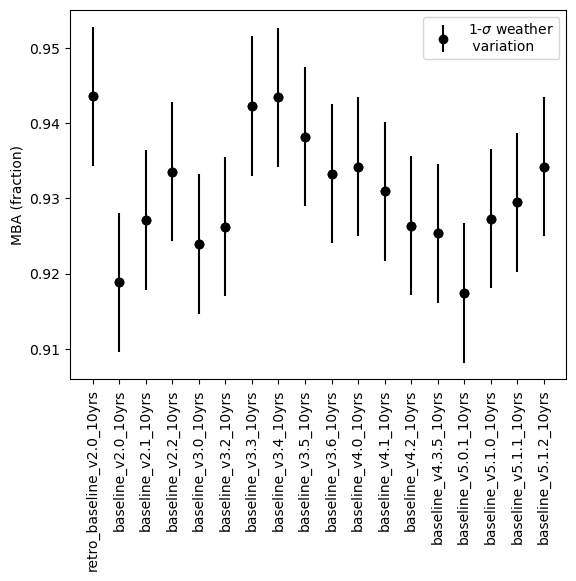

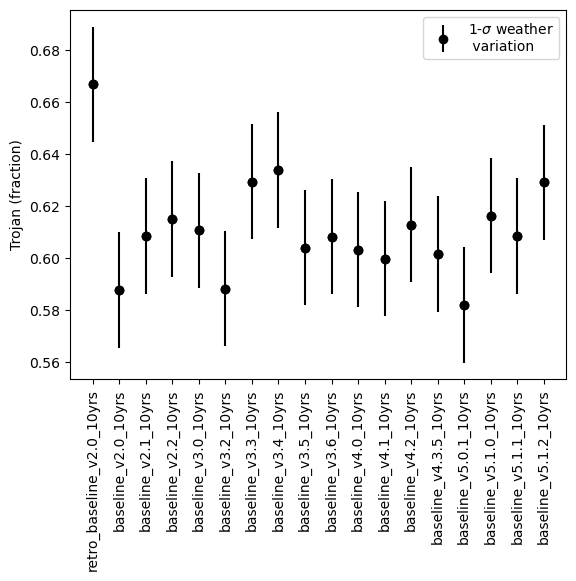

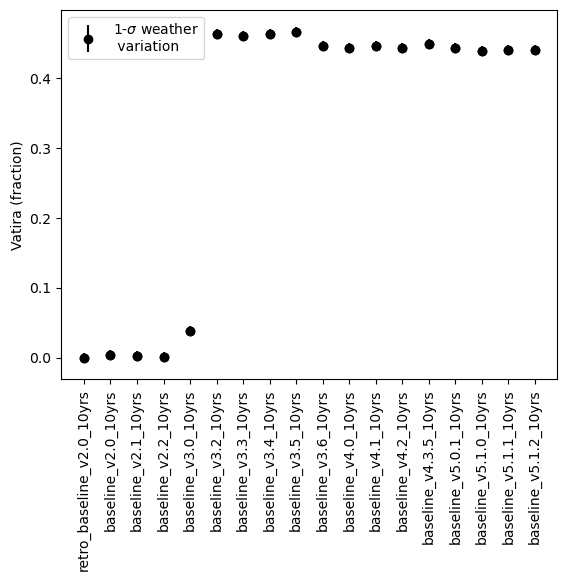

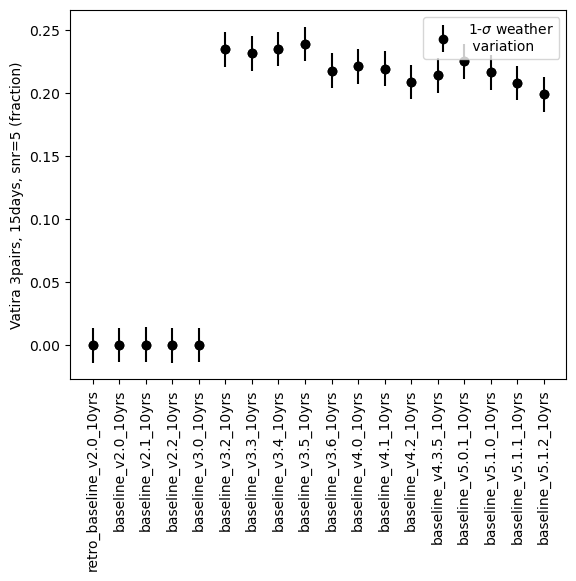

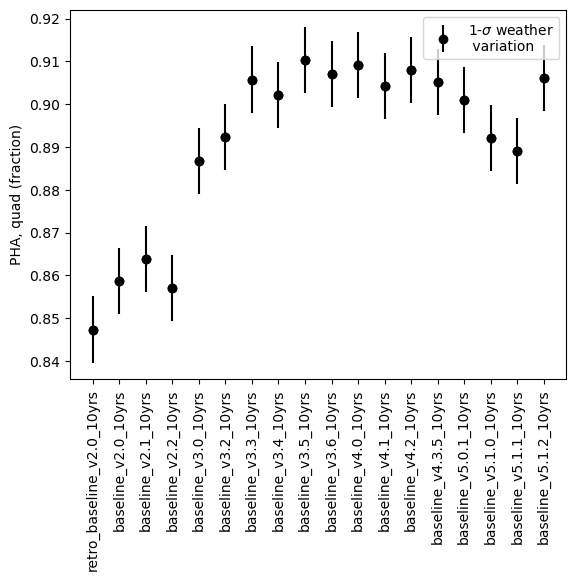

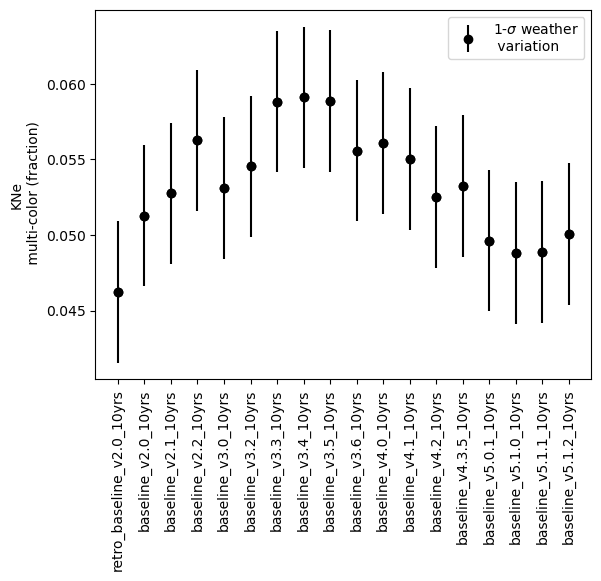

In [21]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run and "5.1.0" in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_75558/647402348.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict2[col], fmt='s', color='k',


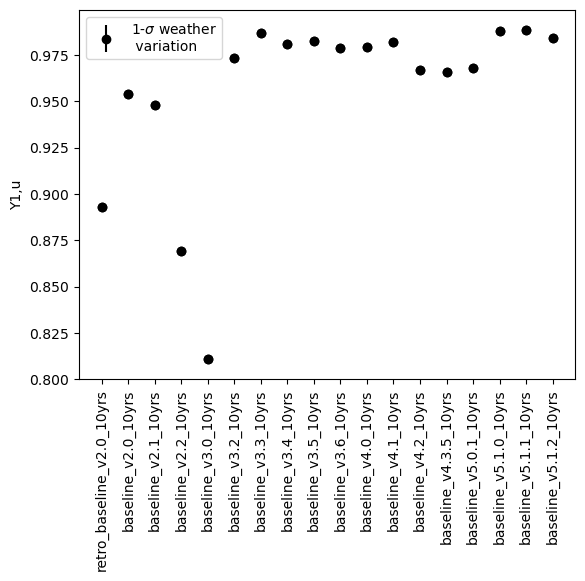

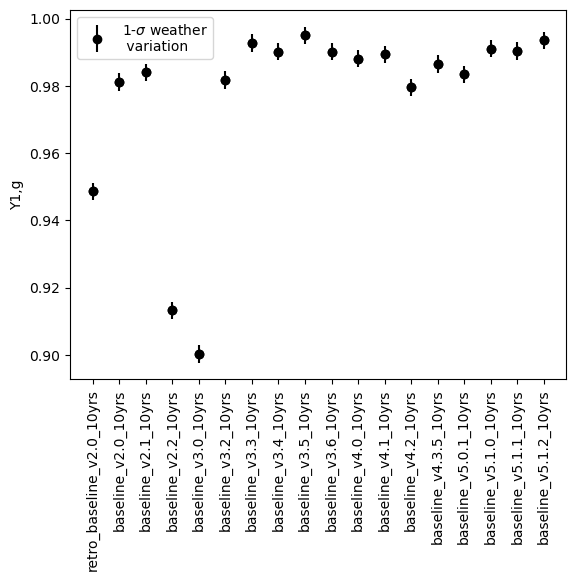

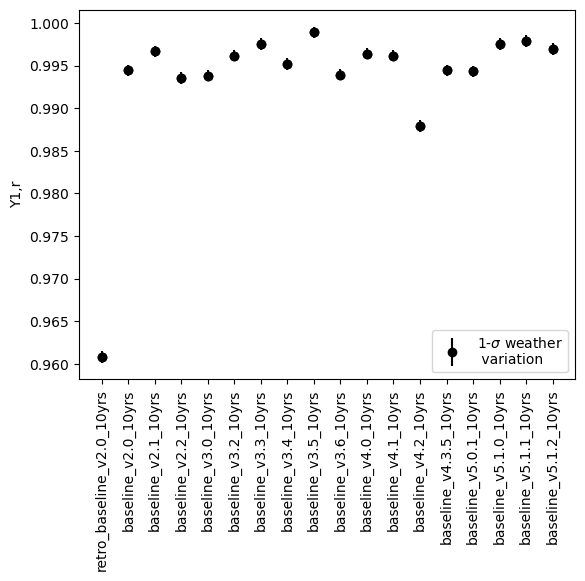

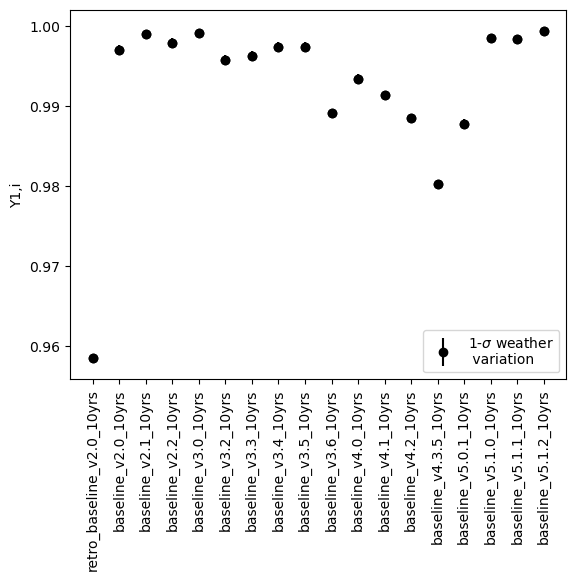

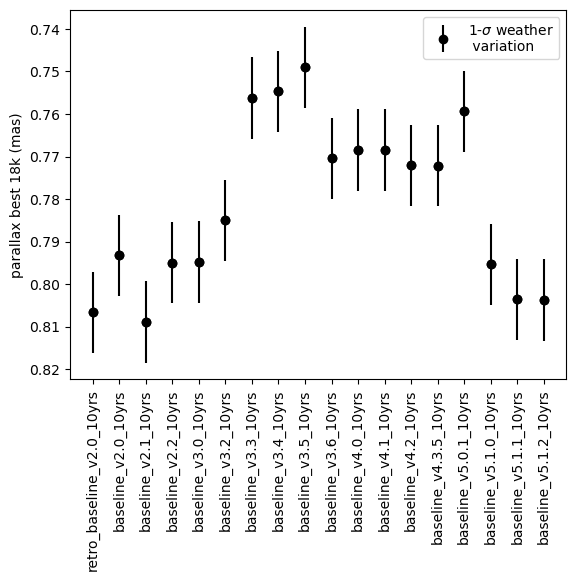

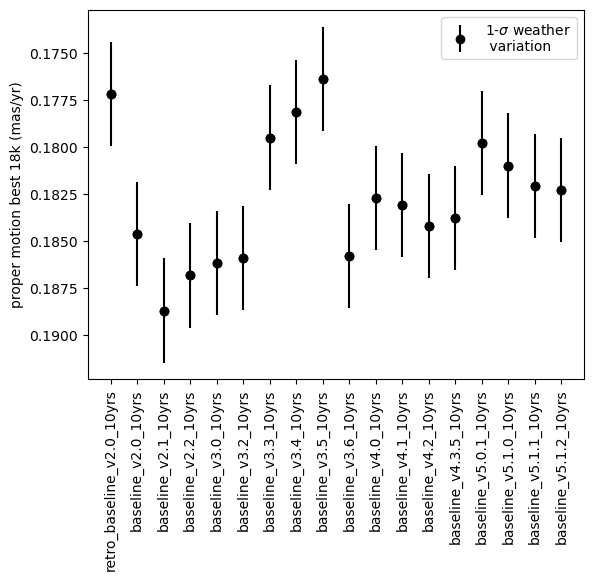

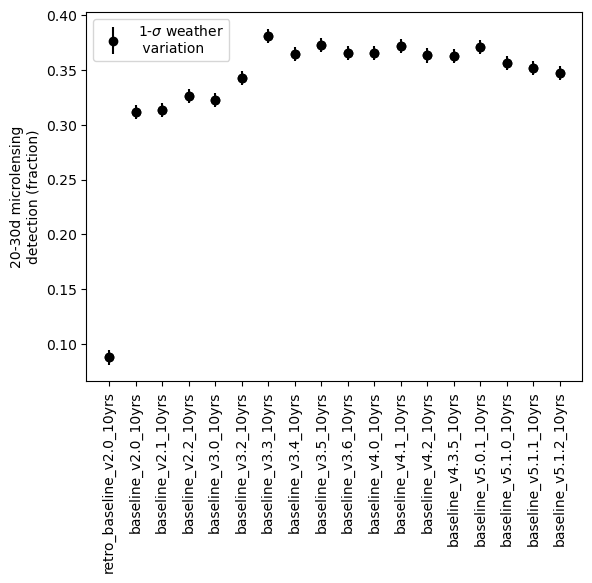

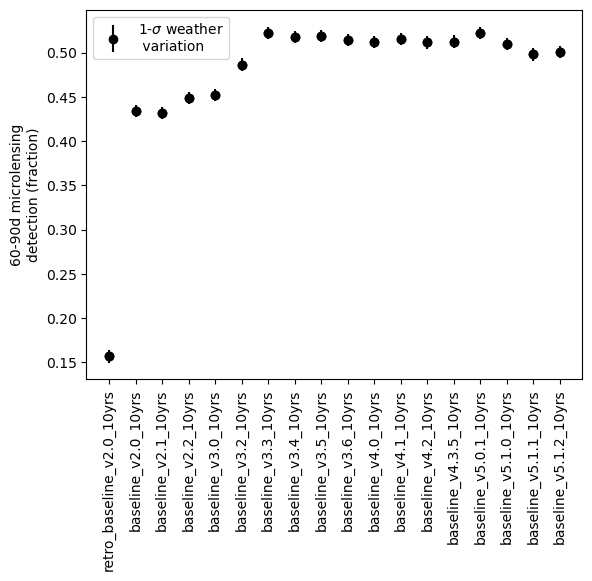

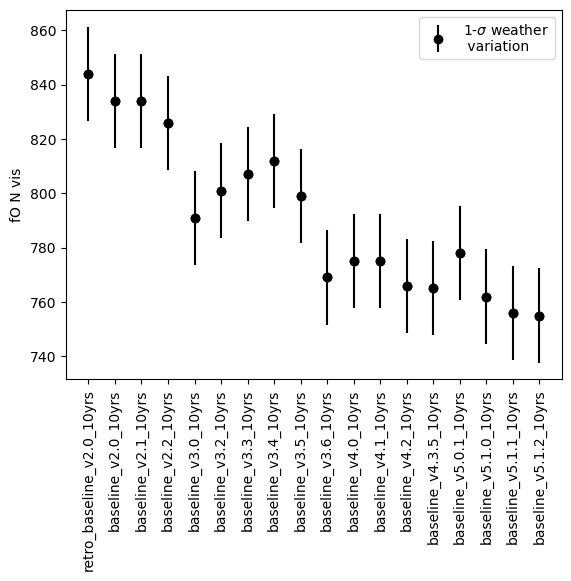

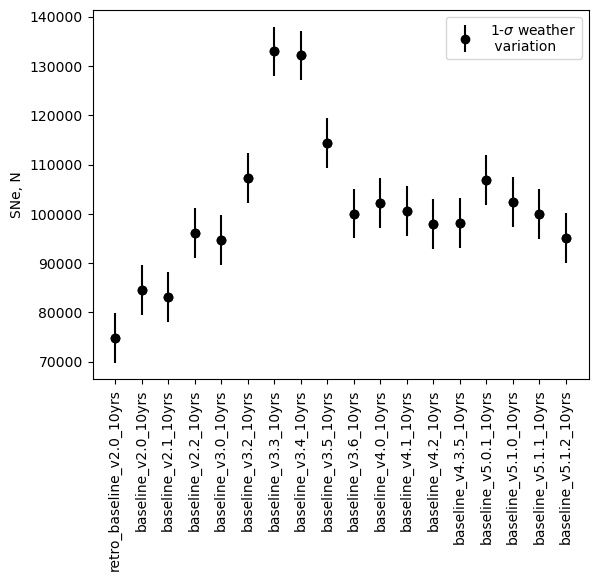

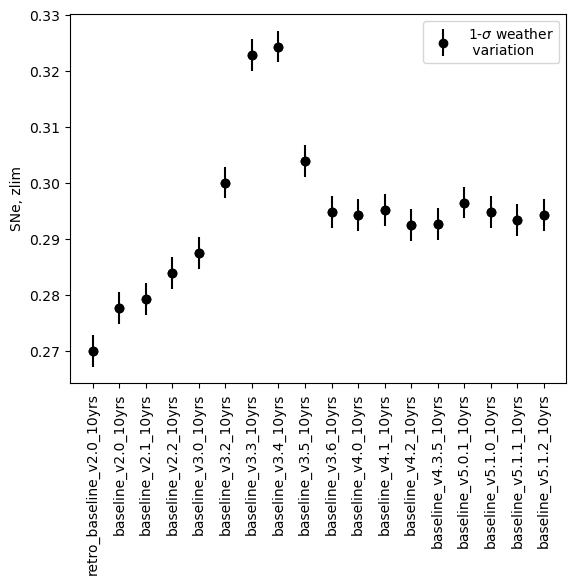

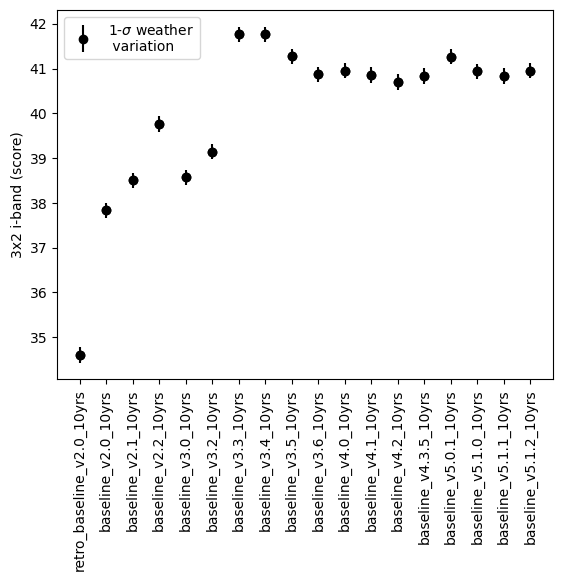

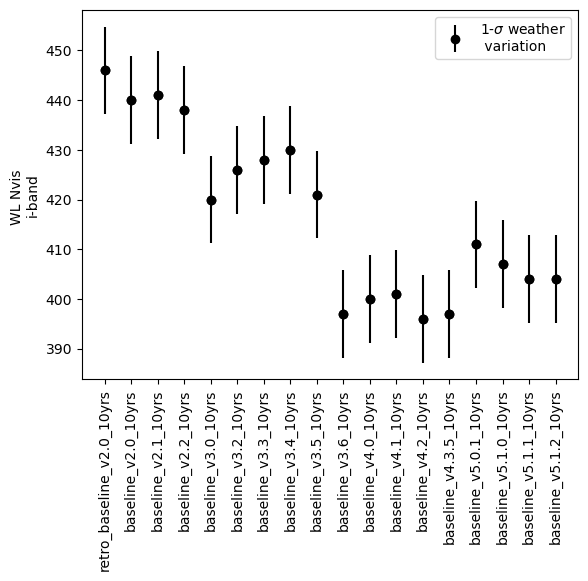

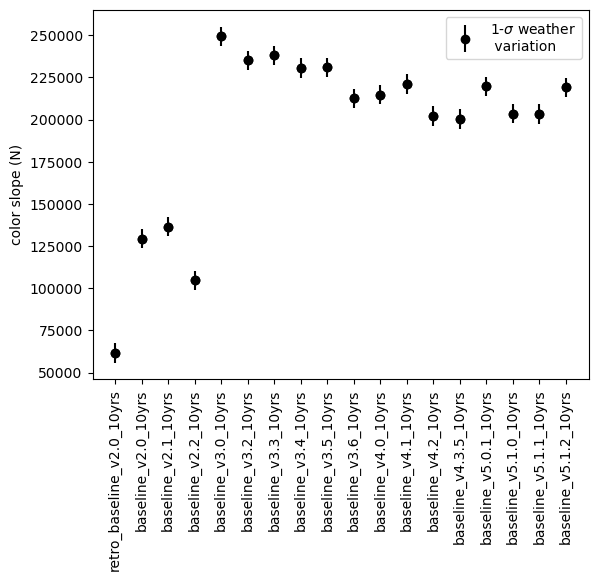

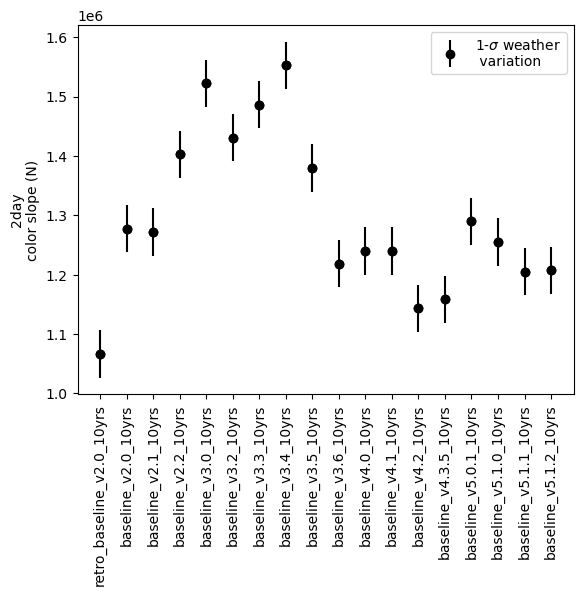

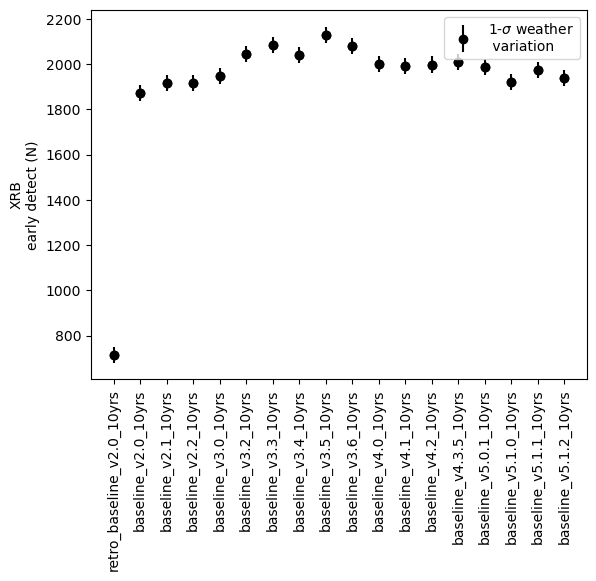

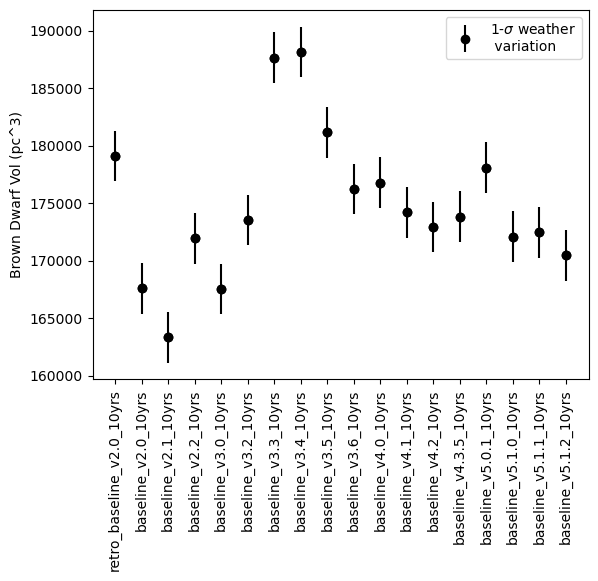

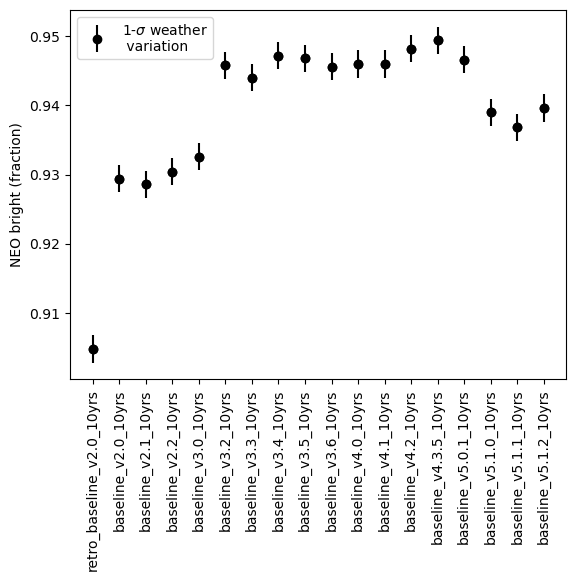

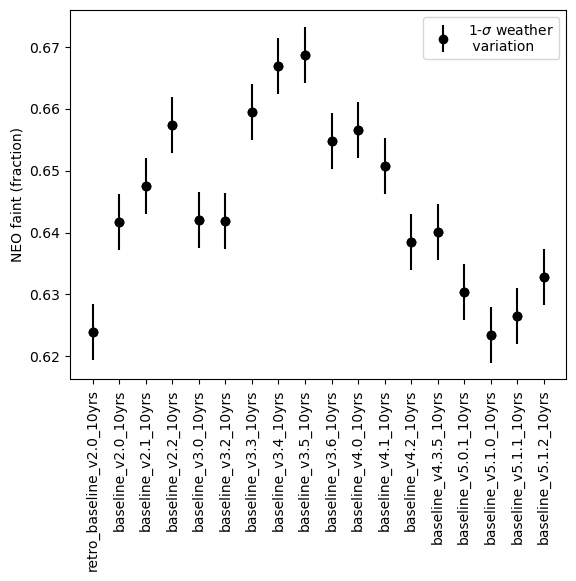

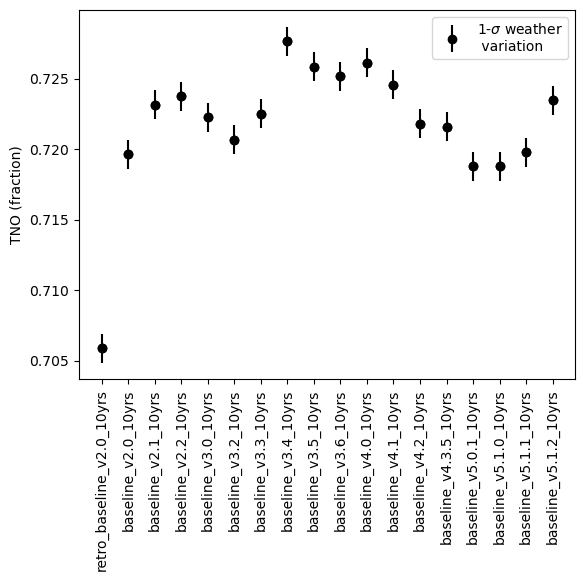

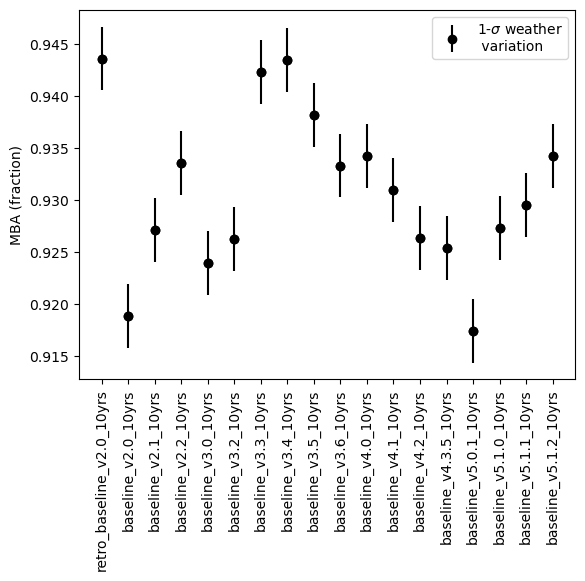

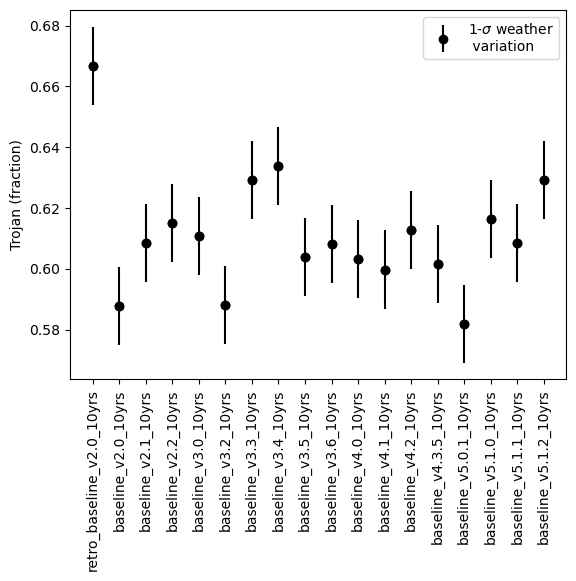

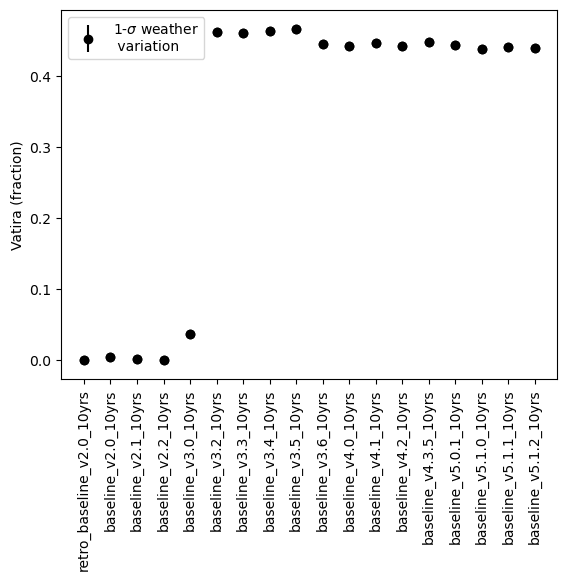

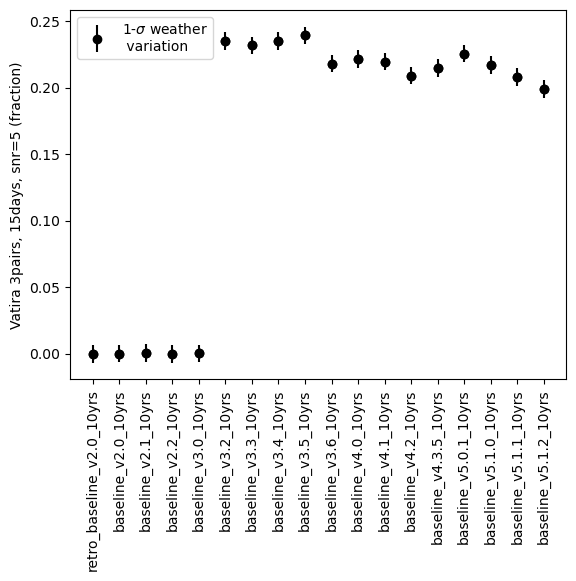

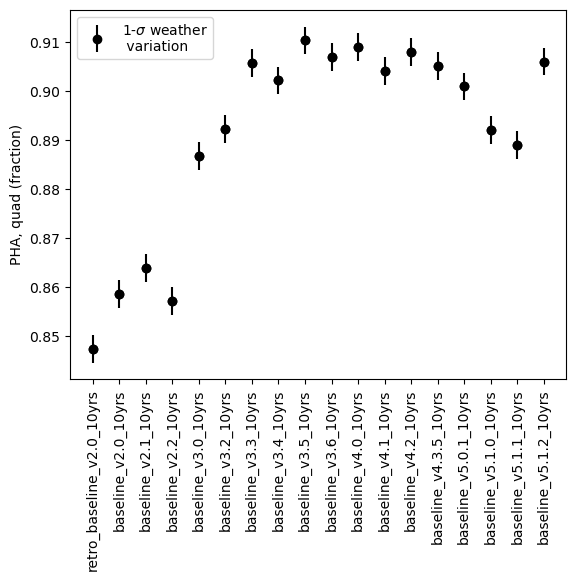

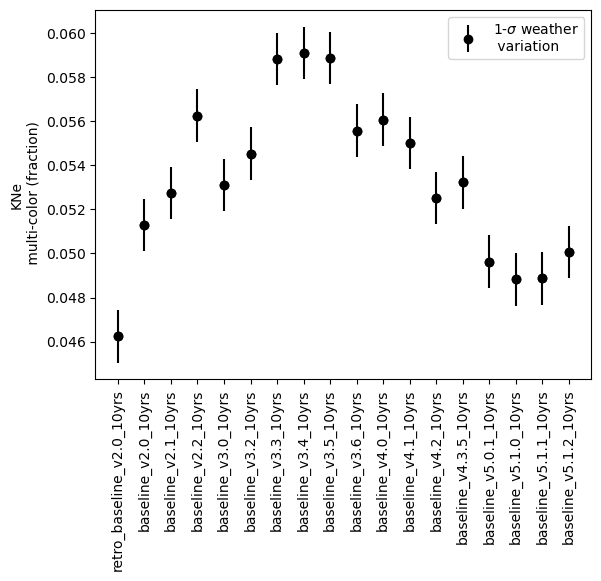

In [22]:
# Rough error bars from weather simulations
std_dict2 = {}
weather_runs = [run for run in data.index if 'weather' in run and "5.1.1" in run]
for col in data.columns:
    std_dict2[col] = np.std(data.loc[weather_runs][col])

std_mag_dict2 = {}
for col in mag_data.columns:
    std_mag_dict2[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict2 = {}
for col in ddf_data.columns:
    std_ddf_dict2[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict2 = {}
for col in gaps_data.columns:
    std_gaps_dict2[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict2[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

In [23]:
std_dict

{'Y1,u': np.float64(0.013547966174331983),
 'Y1,g': np.float64(0.009140411311295397),
 'Y1,r': np.float64(0.002057321874879366),
 'Y1,i': np.float64(0.001568014371241499),
 'parallax best 18k': np.float64(0.03701821773204181),
 'proper motion best 18k': np.float64(0.007282087412848171),
 '20-30d microlensing\ndetection': np.float64(0.013905384683042435),
 '60-90d microlensing\ndetection': np.float64(0.010781462368150602),
 'fO N vis': np.float64(60.566929434935616),
 'SNe, N': np.float64(20200.24626023362),
 'SNe, zlim': np.float64(0.0033138491403502334),
 '3x2 i-band': np.float64(1.225095215677066),
 'WL Nvis \ni-band': np.float64(37.21791979301111),
 'color slope': np.float64(28136.93247788938),
 '2day\ncolor slope': np.float64(194094.2269248393),
 'XRB\nearly detect': np.float64(107.99839804015036),
 'Brown Dwarf Vol': np.float64(5572.205073328084),
 'NEO bright': np.float64(0.00582874395177583),
 'NEO faint': np.float64(0.018532596750865195),
 'TNO': np.float64(0.002272415976552867

In [24]:
std_dict2

{'Y1,u': np.float64(0.0018666448109867766),
 'Y1,g': np.float64(0.0026011242322302283),
 'Y1,r': np.float64(0.0006876295268132387),
 'Y1,i': np.float64(0.0005652037605988562),
 'parallax best 18k': np.float64(0.009557488783153779),
 'proper motion best 18k': np.float64(0.0027705716196007734),
 '20-30d microlensing\ndetection': np.float64(0.0064983531567621095),
 '60-90d microlensing\ndetection': np.float64(0.00695007868660491),
 'fO N vis': np.float64(17.320508075688775),
 'SNe, N': np.float64(5034.8978215400475),
 'SNe, zlim': np.float64(0.0028497188483512614),
 '3x2 i-band': np.float64(0.17233840210429063),
 'WL Nvis \ni-band': np.float64(8.804961314508997),
 'color slope': np.float64(5756.337846438806),
 '2day\ncolor slope': np.float64(39990.38882500394),
 'XRB\nearly detect': np.float64(35.56134664210567),
 'Brown Dwarf Vol': np.float64(2196.190544980216),
 'NEO bright': np.float64(0.001979543823712927),
 'NEO faint': np.float64(0.004529804933071359),
 'TNO': np.float64(0.001029077